# Diets Clutering

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance
from yellowbrick.features import Manifold
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### 1. Loading the dataset and primary data wrangling

In [2]:
## Loading the dataset
df = pd.read_csv("data/All_Diets.csv")
df.head()

,Diet_type,Recipe_name,Cuisine_type,Protein(g),Carbs(g),Fat(g),Extraction_day,Extraction_time
0,paleo,Bone Broth From 'Nom Nom Paleo',american,5.22,1.29,3.20,2022-10-16,17:20:09
1,paleo,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",south east asian,181.55,28.62,146.14,2022-10-16,17:20:09
2,paleo,Paleo Pumpkin Pie,american,30.91,302.59,96.76,2022-10-16,17:20:09
3,paleo,Strawberry Guacamole recipes,mexican,9.62,75.78,59.89,2022-10-16,17:20:09
4,paleo,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",chinese,39.84,54.08,71.55,2022-10-16,17:20:09


#### 1.1. General informations:

In [3]:
df.shape

(7806, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7806 entries, 0 to 7805
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Diet_type        7806 non-null   object 
 1   Recipe_name      7806 non-null   object 
 2   Cuisine_type     7806 non-null   object 
 3   Protein(g)       7806 non-null   float64
 4   Carbs(g)         7806 non-null   float64
 5   Fat(g)           7806 non-null   float64
 6   Extraction_day   7806 non-null   object 
 7   Extraction_time  7806 non-null   object 
dtypes: float64(3), object(5)
memory usage: 488.0+ KB


In [5]:
df.describe()

,Protein(g),Carbs(g),Fat(g)
count,7806.000000,7806.000000,7806.000000
mean,83.231498,152.123189,117.328542
std,89.797282,185.907322,122.098117
min,0.000000,0.060000,0.000000
25%,24.415000,36.162500,41.067500
50%,56.280000,93.415000,84.865000
75%,112.357500,205.915000,158.290000
max,1273.610000,3405.550000,1930.240000


In [6]:
df.isna().sum()

Diet_type          0
Recipe_name        0
Cuisine_type       0
Protein(g)         0
Carbs(g)           0
Fat(g)             0
Extraction_day     0
Extraction_time    0
dtype: int64

#### 1.2. Values in Diet_type ad Cuisine_type:

In [7]:
print(f"Number of unique diet types: {df.Diet_type.unique().shape[0]}")
df.Diet_type.unique()

Number of unique diet types: 5


array(['paleo', 'vegan', 'keto', 'mediterranean', 'dash'], dtype=object)

In [8]:
df.Diet_type.value_counts().keys

<bound method Series.keys of mediterranean    1753
dash             1745
vegan            1522
keto             1512
paleo            1274
Name: Diet_type, dtype: int64>

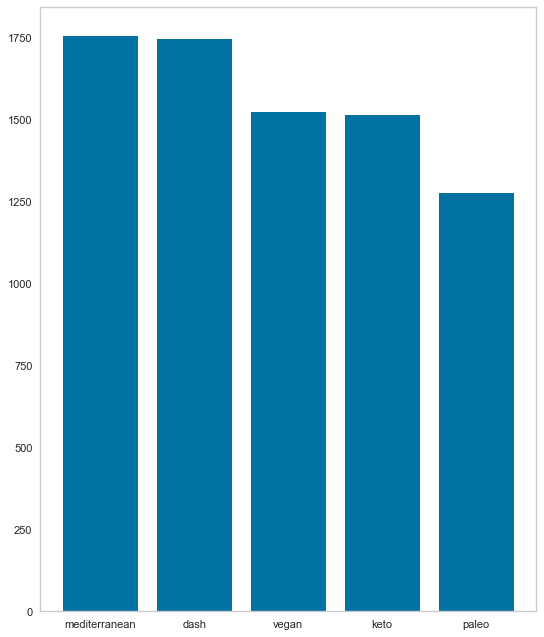

In [9]:
figure(figsize=(8,10), dpi=80)
plt.grid(which="both")
plt.bar(df.Diet_type.value_counts().keys(), df.Diet_type.value_counts().values)
plt.show()

In [10]:
print(f"Number of unique cuisine types: {df.Cuisine_type.unique().shape[0]}")
df.Cuisine_type.unique()

Number of unique cuisine types: 19


array(['american', 'south east asian', 'mexican', 'chinese',
       'mediterranean', 'italian', 'french', 'indian', 'nordic',
       'eastern europe', 'central europe', 'kosher', 'british',
       'caribbean', 'south american', 'middle eastern', 'asian',
       'japanese', 'world'], dtype=object)

In [11]:
df.Cuisine_type.value_counts()

american            2907
mediterranean       1744
italian              799
french               604
world                259
british              239
mexican              224
nordic               152
south east asian     148
south american       137
asian                126
chinese              120
indian                92
middle eastern        91
eastern europe        55
japanese              50
central europe        34
caribbean             18
kosher                 7
Name: Cuisine_type, dtype: int64

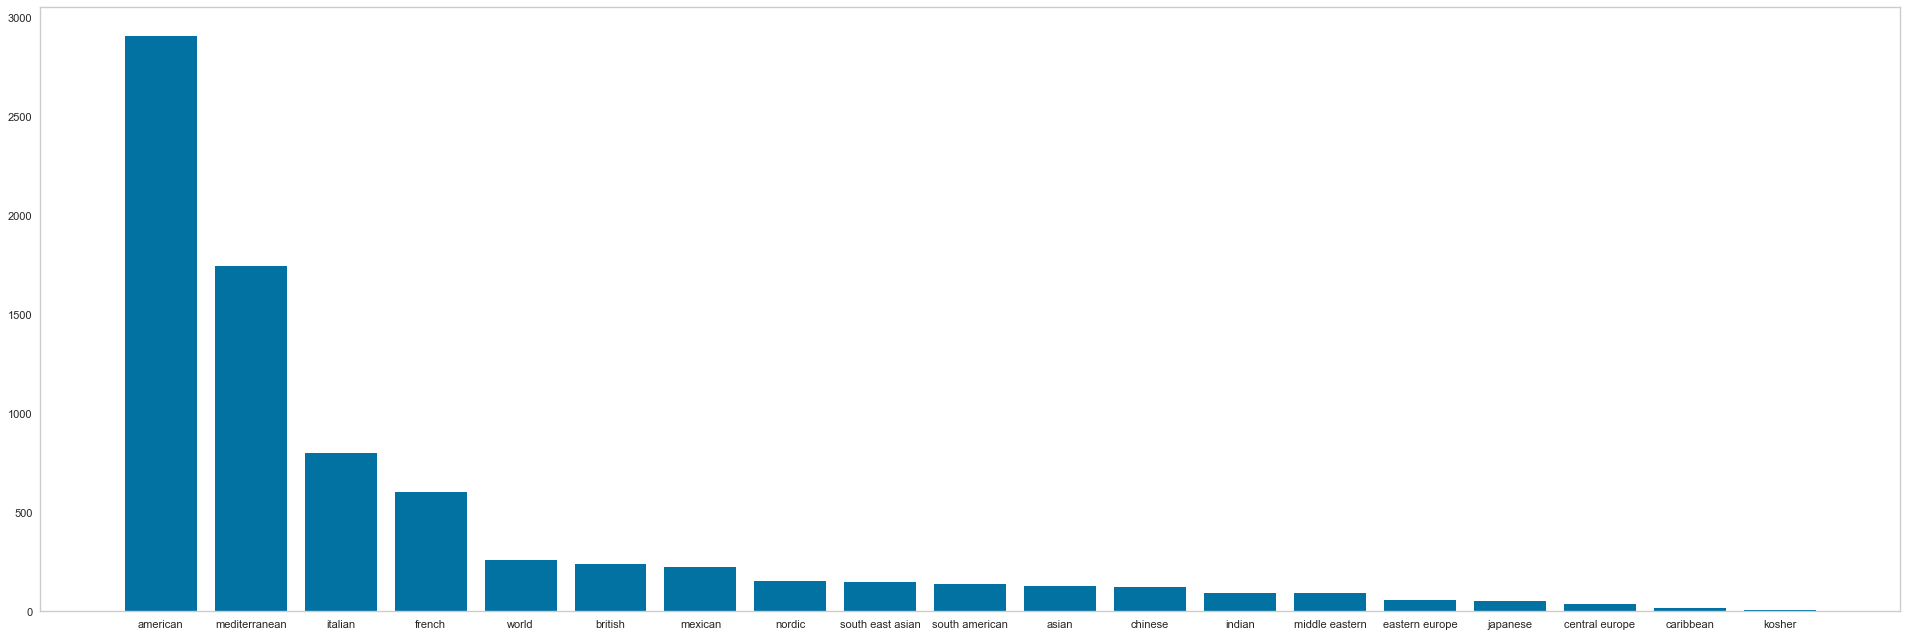

In [12]:
figure(figsize=(30,10), dpi=80)
plt.grid(which="both")
plt.bar(df.Cuisine_type.value_counts().keys(), df.Cuisine_type.value_counts().values)
plt.show()

#### 1.3. Removing Date and Time columns:

In [13]:
df.drop(["Extraction_day","Extraction_time"], axis=1, inplace=True)
df.head()

,Diet_type,Recipe_name,Cuisine_type,Protein(g),Carbs(g),Fat(g)
0,paleo,Bone Broth From 'Nom Nom Paleo',american,5.22,1.29,3.20
1,paleo,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",south east asian,181.55,28.62,146.14
2,paleo,Paleo Pumpkin Pie,american,30.91,302.59,96.76
3,paleo,Strawberry Guacamole recipes,mexican,9.62,75.78,59.89
4,paleo,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",chinese,39.84,54.08,71.55


<div class="alert alert-info">
    <p>After a general overview, we can see that our dataset can be clustered by:</p>
    <u>
        <li>Diet type,</li>
        <li>Cuisine type,</li>
        <li>Nutritional values.</li>
    </ul>
</div>

### 2. Clustering the dataset

#### 2.1. Label Encoding the Diet type and Cuisine type columns:

In [14]:
##Initiating the encoders
diet_encoder = LabelEncoder()
cuisine_encoder = LabelEncoder()

In [15]:
df['Diet_type'] = diet_encoder.fit_transform(df['Diet_type'])

df['Cuisine_type'] = cuisine_encoder.fit_transform(df['Cuisine_type'])

In [16]:
df.head()

,Diet_type,Recipe_name,Cuisine_type,Protein(g),Carbs(g),Fat(g)
0,3,Bone Broth From 'Nom Nom Paleo',0,5.22,1.29,3.20
1,3,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",17,181.55,28.62,146.14
2,3,Paleo Pumpkin Pie,0,30.91,302.59,96.76
3,3,Strawberry Guacamole recipes,13,9.62,75.78,59.89
4,3,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",5,39.84,54.08,71.55


#### 2.2. Clustering:

In [17]:
df_diet = df.drop("Recipe_name", axis=1)

In [18]:
mm_s = MinMaxScaler()
df_diet_scaled = mm_s.fit_transform(df_diet)

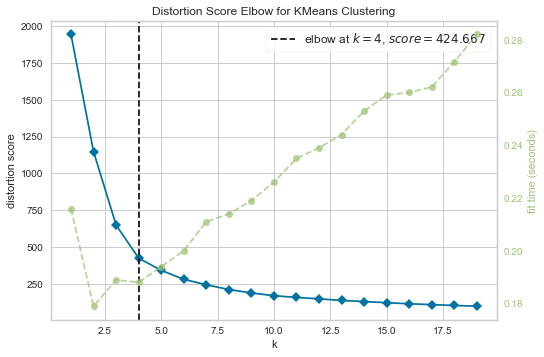

<Figure size 800x640 with 0 Axes>

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
i=1
kmean = KMeans(n_clusters=i, random_state=42)
visualizer = KElbowVisualizer(kmean, k=(1,20), timings= True)
visualizer.fit(df_diet_scaled)        # Fit data to visualizer
figure(figsize=(10,8), dpi=80)
visualizer.show()        # Finalize and render figure

In [20]:
clustering = KMeans(n_clusters=4, random_state=42)
clustering.fit(df_diet_scaled)

KMeans(n_clusters=4, random_state=42)

In [21]:
df["Clusters"] = clustering.labels_

In [22]:
df.head()

,Diet_type,Recipe_name,Cuisine_type,Protein(g),Carbs(g),Fat(g),Clusters
0,3,Bone Broth From 'Nom Nom Paleo',0,5.22,1.29,3.20,3
1,3,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",17,181.55,28.62,146.14,1
2,3,Paleo Pumpkin Pie,0,30.91,302.59,96.76,3
3,3,Strawberry Guacamole recipes,13,9.62,75.78,59.89,1
4,3,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",5,39.84,54.08,71.55,3


#### 2.3. Plot intersections between clusters:

#### 2.3.1. General overview:

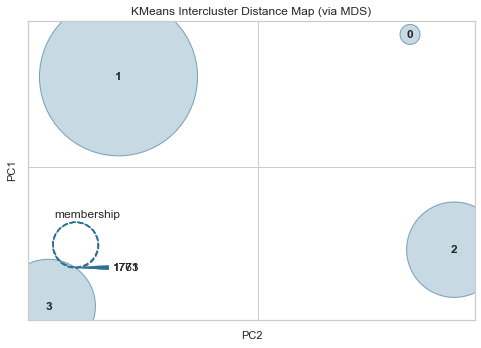

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [23]:
visualizer = InterclusterDistance(clustering, random_state=42)

visualizer.fit(df_diet_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

##### 2.3.2. 3D Plot with the 3 nutritional value axis:

Text(0.5, 0, 'Fat(g)')

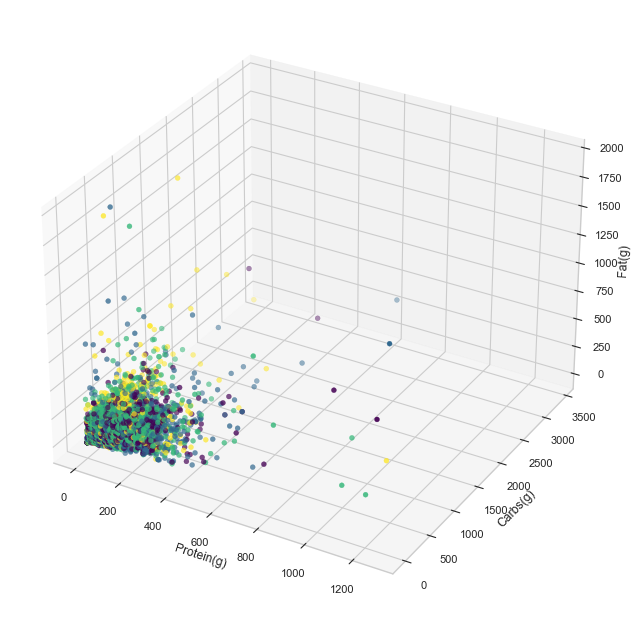

In [24]:
fig = plt.figure(figsize=(10,10), dpi=80)
ax = plt.axes(projection='3d')

ax.scatter3D(df["Protein(g)"].values, df["Carbs(g)"].values, df["Fat(g)"].values, c = df["Clusters"], cmap = "viridis")
ax.set_xlabel("Protein(g)")
ax.set_ylabel("Carbs(g)")
ax.set_zlabel("Fat(g)")

##### 2.3.3. Scatter plot with PCA (2D):

In [25]:
pca = PCA(n_components=2,random_state=42)

In [26]:
features = pca.fit_transform(df_diet_scaled)

In [27]:
features.shape

(7806, 2)

In [28]:
df_pca = pd.DataFrame({})

In [29]:
df_pca["PCA_1"] = features[:,0]
df_pca["PCA_2"] = features[:,1]
df_pca["Clusters"] = df["Clusters"]

In [30]:
df_pca.shape

(7806, 3)

Text(0, 0.5, 'PCA_2')

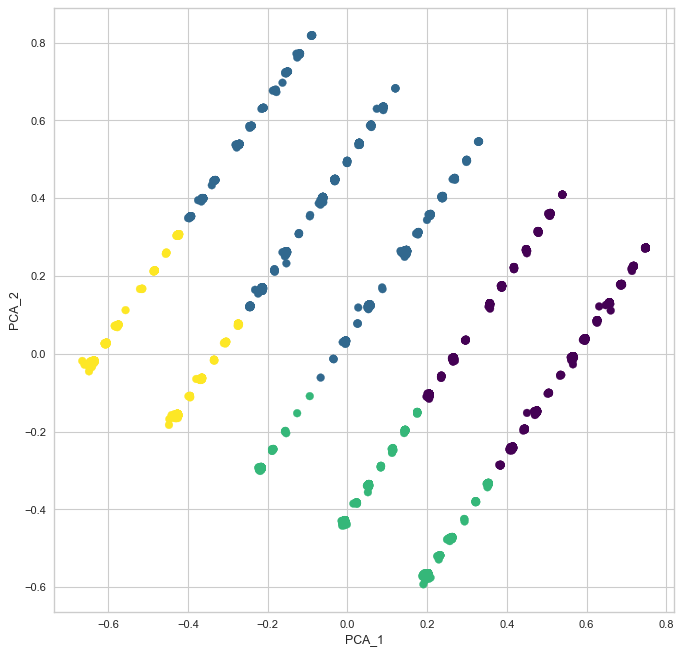

In [31]:
fig = plt.figure(figsize=(10,10), dpi=80)
ax = plt.axes()

ax.scatter(df_pca["PCA_1"].values, df_pca["PCA_2"].values, c = df_pca["Clusters"], cmap = "viridis")
ax.set_xlabel("PCA_1")
ax.set_ylabel("PCA_2")

##### 2.3.4. Scatter plot with PCA (3D):

In [32]:
pca = PCA(n_components=3,random_state=42)

In [33]:
features = pca.fit_transform(df_diet_scaled)

In [34]:
features.shape

(7806, 3)

In [35]:
df_pca_1 = pd.DataFrame({})

In [36]:
df_pca_1["PCA_1"] = features[:,0]
df_pca_1["PCA_2"] = features[:,1]
df_pca_1["PCA_3"] = features[:,2]
df_pca_1["Clusters"] = df["Clusters"]

In [37]:
df_pca_1.shape

(7806, 4)

Text(0.5, 0, 'PCA_3')

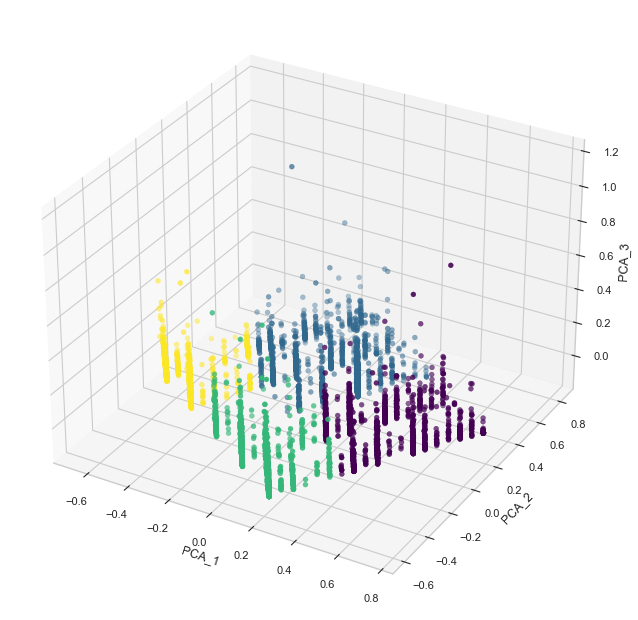

In [38]:
fig = plt.figure(figsize=(10,10), dpi=80)
ax = plt.axes(projection='3d')

ax.scatter3D(df_pca_1["PCA_1"].values, df_pca_1["PCA_2"].values, df_pca_1["PCA_3"].values, c = df_pca_1["Clusters"], cmap = "viridis")
ax.set_xlabel("PCA_1")
ax.set_ylabel("PCA_2")
ax.set_zlabel("PCA_3")

### 3. Analyzing the data

<div class="alert alert-info">
    <p>We clutered the data, visualized the cluters using <b>PCA</b> in 2D and 3D. Now we must understand the data within the clusters to better comprehend <i>"Why the values in a cluter where put together? And what insight do they hold?"</i></p>
</div>

#### 3.1. Inerse the label encoding:

In [39]:
df["Diet_type"] = diet_encoder.inverse_transform(df["Diet_type"])

df["Cuisine_type"] = cuisine_encoder.inverse_transform(df["Cuisine_type"])

In [40]:
df.head()

,Diet_type,Recipe_name,Cuisine_type,Protein(g),Carbs(g),Fat(g),Clusters
0,paleo,Bone Broth From 'Nom Nom Paleo',american,5.22,1.29,3.20,3
1,paleo,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",south east asian,181.55,28.62,146.14,1
2,paleo,Paleo Pumpkin Pie,american,30.91,302.59,96.76,3
3,paleo,Strawberry Guacamole recipes,mexican,9.62,75.78,59.89,1
4,paleo,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",chinese,39.84,54.08,71.55,3


#### 3.2. Visualization by cluster:

##### 3.2.1. Nutritional values:

<Figure size 2400x800 with 0 Axes>

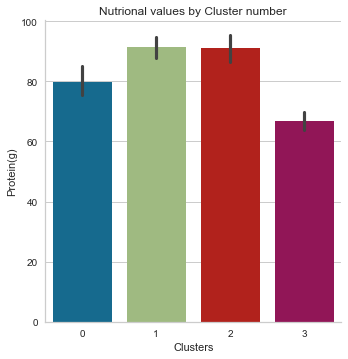

<Figure size 2400x800 with 0 Axes>

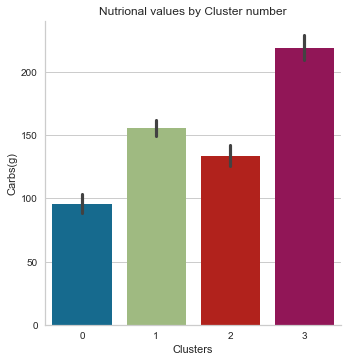

<Figure size 2400x800 with 0 Axes>

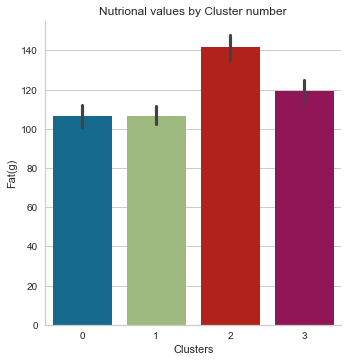

In [41]:
for col in df.columns[3:6]:
    figure(figsize=(30,10), dpi=80)
    sns.catplot(
        data=df, x="Clusters", y=col,
        kind="bar")
    plt.title(f"Nutrional values by Cluster number")
    plt.show()

##### 3.2.2. Diet type:

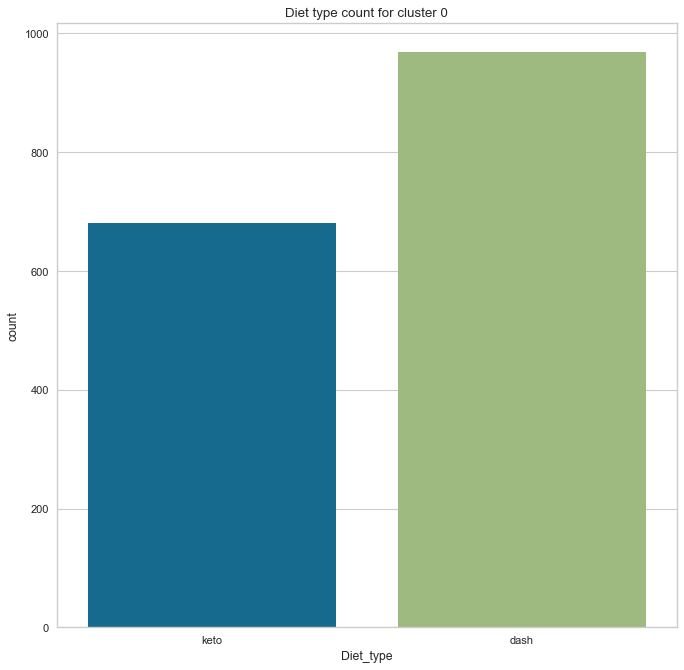

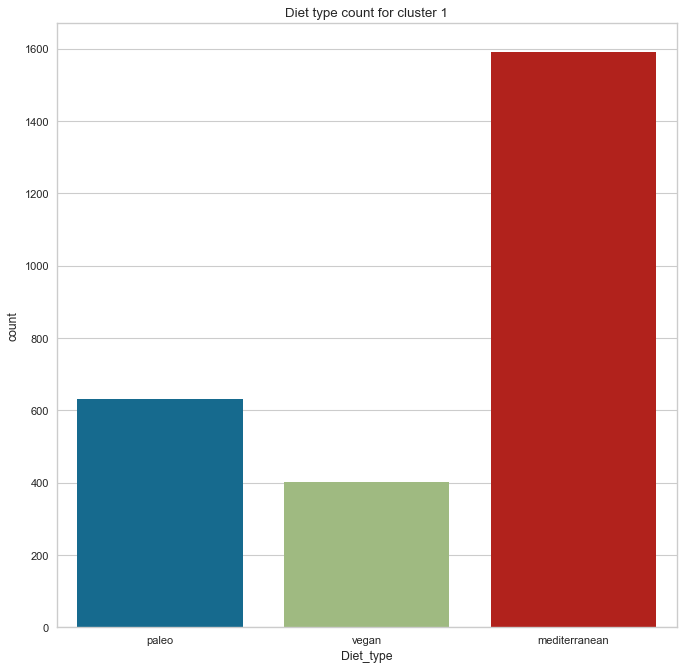

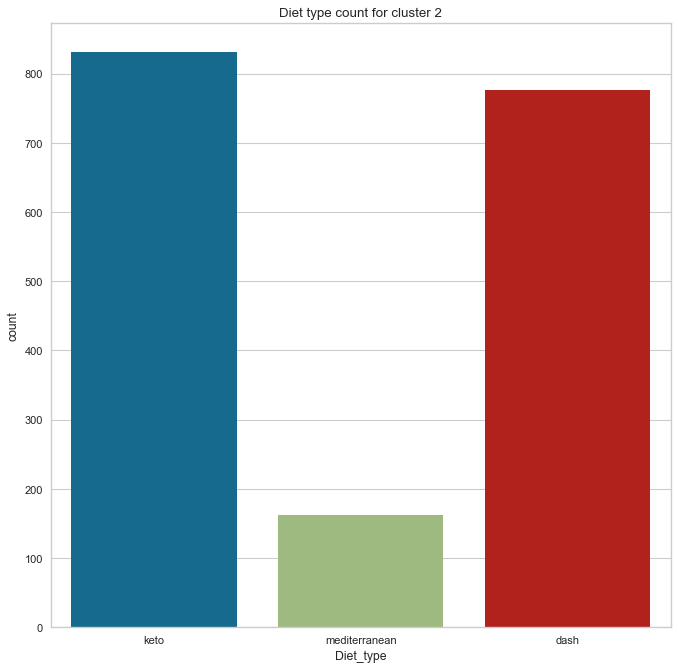

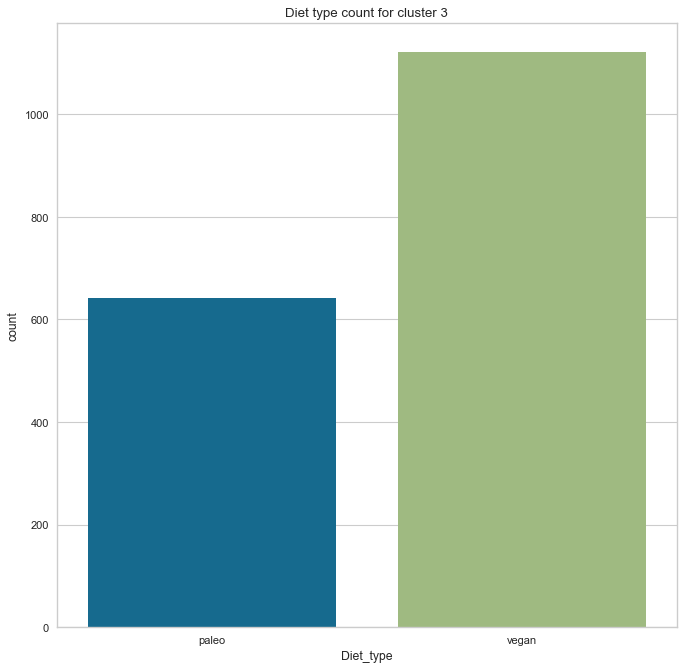

In [42]:
for i in range(4):
    figure(figsize=(10,10), dpi=80)
    sns.countplot(x=df.loc[df.Clusters == i, "Diet_type"])
    plt.title(f"Diet type count for cluster {i}")
    plt.show()

##### 3.2.3. Cuisine type:

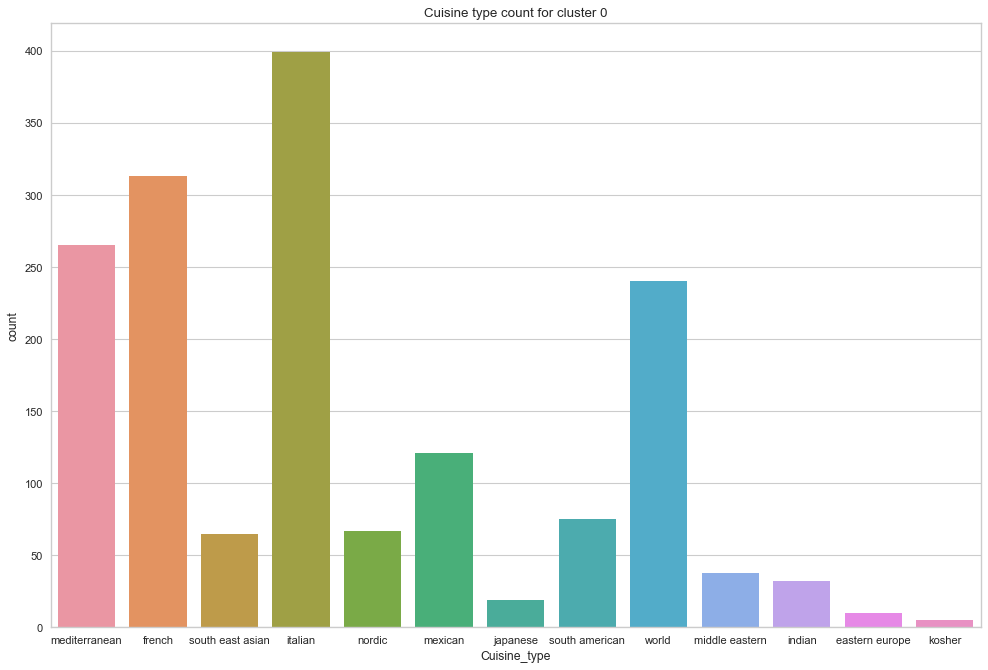

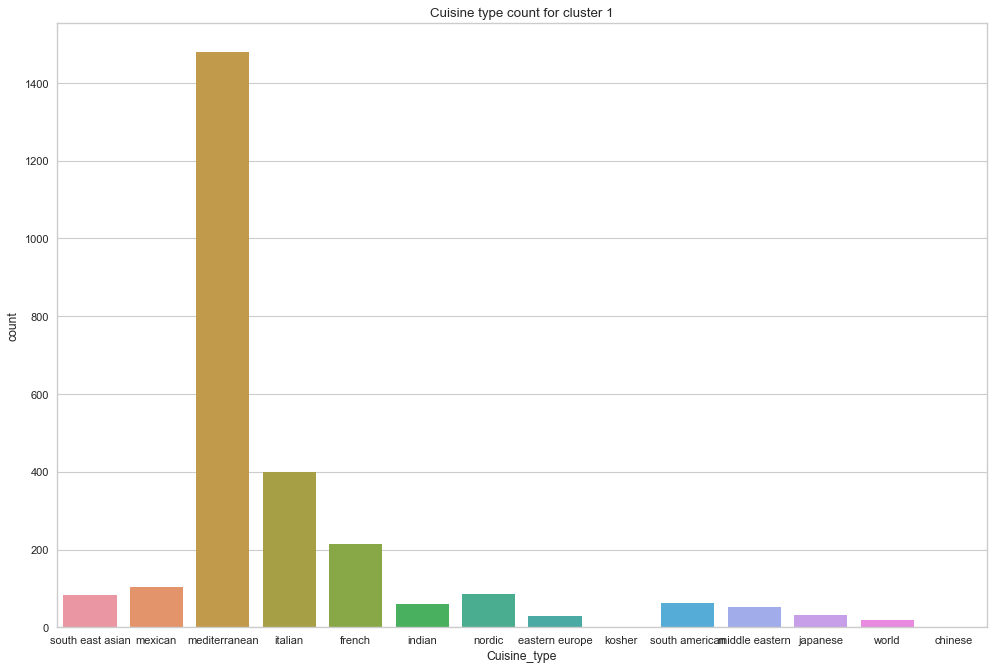

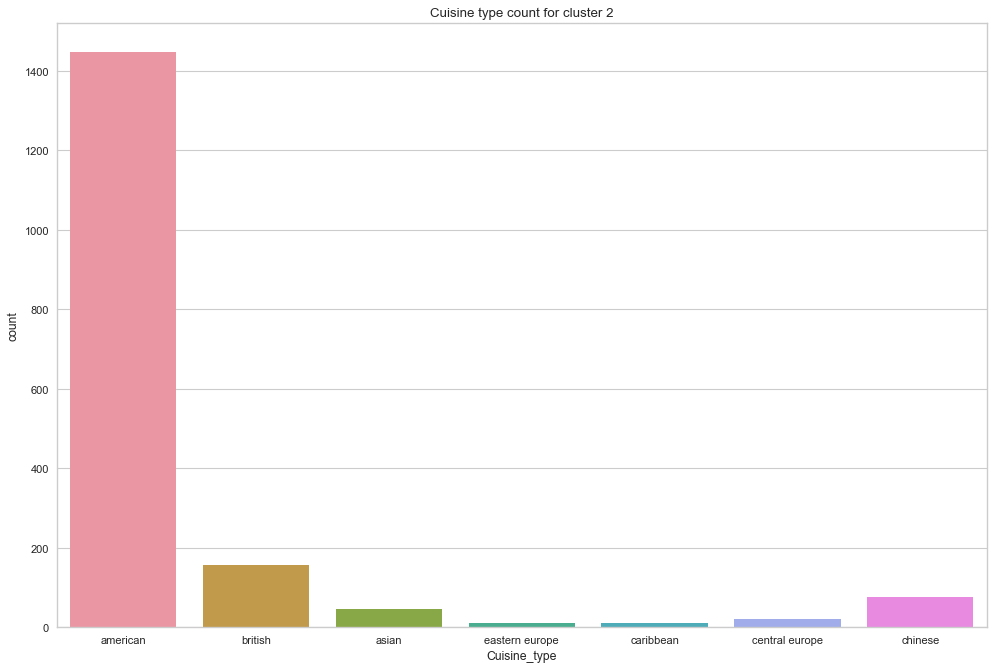

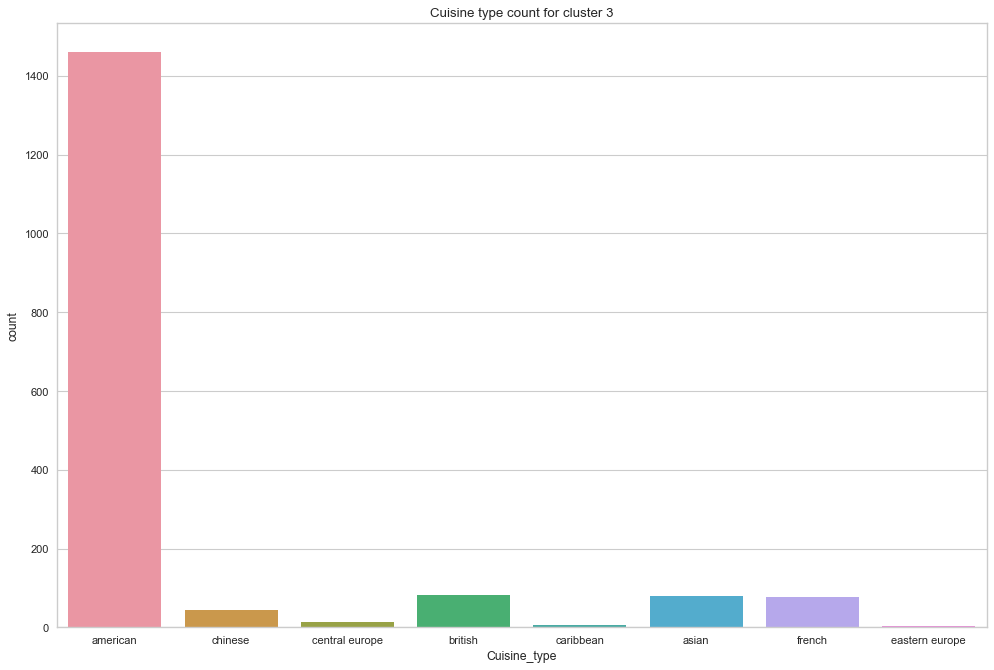

In [43]:
for i in range(4):
    figure(figsize=(15,10), dpi=80)
    sns.countplot(x=df.loc[df.Clusters == i, "Cuisine_type"])
    plt.title(f"Cuisine type count for cluster {i}")
    plt.show()

<div class="alert alert-info">
    <p>After a thorow observation, we made our dedoctions that best explain the each cluster.</p>
    <br/>
    <p>Firstly, after looking at the sparced nutiritional values (<u>Proteins</u>, <u>Carbs</u> and <u>Fats</u>) for each cluster, we deduced that the <u>Protein</u> feature was less deterministique for the clusters devision. But, on the other hand, the <u>Carbs and Fats</u> features, depending on who was more dominant than who, played a big role in dividing the dataset into <b>two clusters</b> (one where <i>Carbs</i> were more dominant than <i>Fats</i> and vice versa). However, there are still two other clusters missing.</p>
    <br/>
    <p>Secondly, we found our tie breaker that explained why there where <b>4 clusters</b>, the <u>Diet type</u>.
        There are 4 commen <u>Diet types</u> dispersed as follow:
    <ul>
        <li>For those where <u>Fats</u> >>> <u>Carbs</u>: <i>dash</i> and <i>keto</i>.</li>
        <li>For those where <u>Carbs</u> >>> <u>Fats</u>: <i>paleo</i> and <i>vegan</i>.</li>
    </ul>
    They each change in dominace like how <u>Carbs</u> and <u>Fats</u> do. But there is <u>another diet type</u> that played the role of the final deterministique on choosing which cluster, <i>the mediterranean diet</i>, and we can fin in in both <u>Carbs dominant</u> and <u>Fats dominant</u> clusters.
    </p>
</div>

<div class="alert alert-info">
    <p>In conclusion, we know that the deciding features on what <u>meal to choose for your diet</u> are <b>Carbs, Fats, and Diet type.</b> The <b>Cuisine type</b> is not very deterministique but it holds some useful insight to better cluster. And we deduced that the <u>medeterranean diet</u> is the most commen.</p>
</div>

### 4. Buiding a model for predicting the classe:

#### 4.1. Feature selection:

##### 4.1.1. Check labels balance:

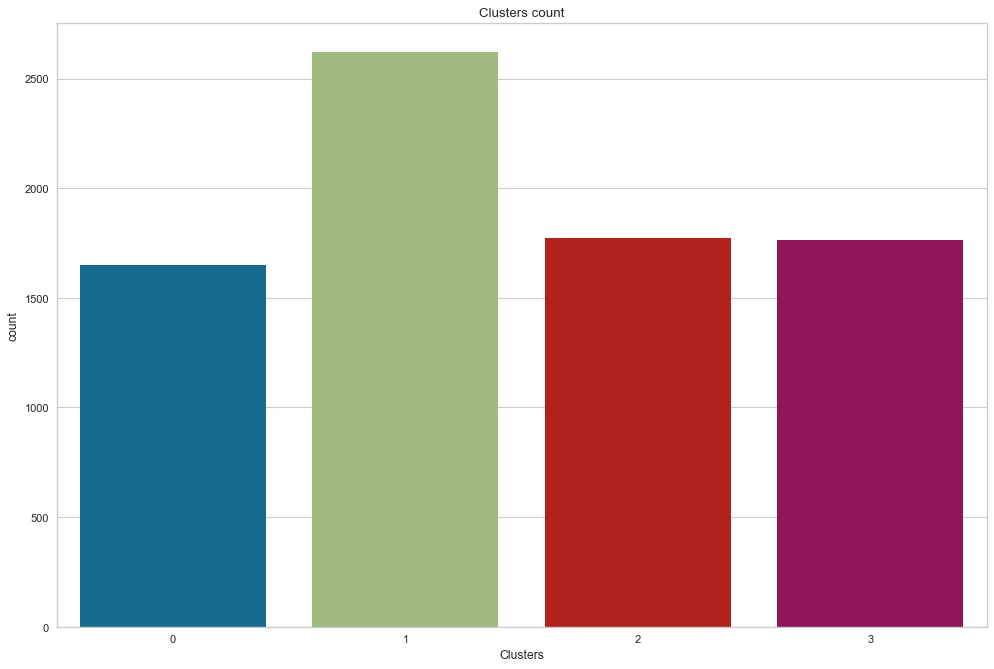

In [44]:
figure(figsize=(15,10), dpi=80)
sns.countplot(x=df.Clusters)
plt.title(f"Clusters count")
plt.show()

In [45]:
df["Clusters"].value_counts()

1    2623
2    1771
3    1763
0    1649
Name: Clusters, dtype: int64

##### 4.4.2. Reencoding and selecting the features:

In [46]:
df['Diet_type'] = diet_encoder.fit_transform(df['Diet_type'])

df['Cuisine_type'] = cuisine_encoder.fit_transform(df['Cuisine_type'])

In [47]:
df.head()

,Diet_type,Recipe_name,Cuisine_type,Protein(g),Carbs(g),Fat(g),Clusters
0,3,Bone Broth From 'Nom Nom Paleo',0,5.22,1.29,3.20,3
1,3,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",17,181.55,28.62,146.14,1
2,3,Paleo Pumpkin Pie,0,30.91,302.59,96.76,3
3,3,Strawberry Guacamole recipes,13,9.62,75.78,59.89,1
4,3,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",5,39.84,54.08,71.55,3


In [48]:
##Undersampling
count_1, count_2, count_3, count_0 = df["Clusters"].value_counts()
df_class_0 = df[df["Clusters"] == 0]
df_class_1 = df[df["Clusters"] == 1]
df_class_2 = df[df["Clusters"] == 2]
df_class_3 = df[df["Clusters"] == 3]

In [49]:
df_under = pd.concat([df_class_0, df_class_1.sample(count_0), df_class_2.sample(count_0), df_class_3.sample(count_0)])

In [50]:
df_under["Clusters"].value_counts()

0    1649
1    1649
2    1649
3    1649
Name: Clusters, dtype: int64

In [51]:
df_under = df_under.sample(frac=1)

In [52]:
X,y = df_under.drop(['Recipe_name', 'Clusters'], axis=1), df_under['Clusters']

#### 4.2. Models training and evaluation:

In [53]:
def evaluation(y_true, y_pred):
    print("Testing Score:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    
def build(X,y,model, n=3):
    kf = KFold(n_splits=n, shuffle=True, random_state=42)
    mm_s = MinMaxScaler()
    model_list = []
    n_fold = 0
    for train_index, test_index in kf.split(X):
        print(f"\n###### Fold number {n_fold+1} ######\n")
        #Split the data into training and testing
        print("TRAIN:", len(train_index)/len(X), "TEST:", len(test_index)/len(X),"\n")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train = mm_s.fit_transform(X_train)
        X_test = mm_s.transform(X_test)
        #Train the model
        model.fit(X_train, y_train)
        model_list.append((model, mm_s))
        n_fold += 1
        ##Evaluation
        ypred = model.predict(X_test)
        # print(y_test)
        print("Training score:",model.score(X_train, y_train),"\n")
        evaluation(y_test, ypred)

    return model_list

##### 4.2.1. Logistic Regression:

In [54]:
lr_list = build(X,y, LogisticRegression(), n=5)


###### Fold number 1 ######

TRAIN: 0.7998787143723469 TEST: 0.20012128562765313 

Training score: 0.9836997725549659 

Testing Score: 0.9825757575757575
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       319
           1       0.96      1.00      0.98       319
           2       1.00      0.97      0.99       340
           3       1.00      0.96      0.98       342

    accuracy                           0.98      1320
   macro avg       0.98      0.98      0.98      1320
weighted avg       0.98      0.98      0.98      1320


###### Fold number 2 ######

TRAIN: 0.8000303214069133 TEST: 0.19996967859308673 

Training score: 0.9842713663066136 

Testing Score: 0.9825625473843821
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       356
           1       0.96      1.00      0.98       335
           2       1.00      0.97      0.99       312
           3       1.00      0.95     

##### 4.2.2. Support Vector Classifier:

In [55]:
svc_list = build(X,y, SVC(), n=5)


###### Fold number 1 ######

TRAIN: 0.7998787143723469 TEST: 0.20012128562765313 

Training score: 0.9992418498862775 

Testing Score: 0.9992424242424243
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           1       1.00      1.00      1.00       319
           2       1.00      1.00      1.00       340
           3       1.00      1.00      1.00       342

    accuracy                           1.00      1320
   macro avg       1.00      1.00      1.00      1320
weighted avg       1.00      1.00      1.00      1320


###### Fold number 2 ######

TRAIN: 0.8000303214069133 TEST: 0.19996967859308673 

Training score: 0.9984839871138904 

Testing Score: 0.9984836997725549
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       356
           1       1.00      1.00      1.00       335
           2       1.00      0.99      1.00       312
           3       1.00      1.00     

##### 4.2.3. Decision tree:

In [56]:
dt_list = build(X,y, DecisionTreeClassifier(), n=5)


###### Fold number 1 ######

TRAIN: 0.7998787143723469 TEST: 0.20012128562765313 

Training score: 1.0 

Testing Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           1       1.00      1.00      1.00       319
           2       1.00      1.00      1.00       340
           3       1.00      1.00      1.00       342

    accuracy                           1.00      1320
   macro avg       1.00      1.00      1.00      1320
weighted avg       1.00      1.00      1.00      1320


###### Fold number 2 ######

TRAIN: 0.8000303214069133 TEST: 0.19996967859308673 

Training score: 1.0 

Testing Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       356
           1       1.00      1.00      1.00       335
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       316

    accuracy                           1.00

##### 4.2.4. Random forest:

In [57]:
rf_list = build(X,y, RandomForestClassifier(), n=5)


###### Fold number 1 ######

TRAIN: 0.7998787143723469 TEST: 0.20012128562765313 

Training score: 1.0 

Testing Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           1       1.00      1.00      1.00       319
           2       1.00      1.00      1.00       340
           3       1.00      1.00      1.00       342

    accuracy                           1.00      1320
   macro avg       1.00      1.00      1.00      1320
weighted avg       1.00      1.00      1.00      1320


###### Fold number 2 ######

TRAIN: 0.8000303214069133 TEST: 0.19996967859308673 

Training score: 1.0 

Testing Score: 0.9992418498862775
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       356
           1       1.00      1.00      1.00       335
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       316

    accuracy                

##### 4.2.5. Ada Boost:

In [58]:
ab_list = build(X,y, AdaBoostClassifier(), n=5)


###### Fold number 1 ######

TRAIN: 0.7998787143723469 TEST: 0.20012128562765313 

Training score: 0.9649355572403336 

Testing Score: 0.9613636363636363
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           1       0.96      1.00      0.98       319
           2       1.00      0.89      0.94       340
           3       0.90      0.96      0.93       342

    accuracy                           0.96      1320
   macro avg       0.96      0.96      0.96      1320
weighted avg       0.96      0.96      0.96      1320


###### Fold number 2 ######

TRAIN: 0.8000303214069133 TEST: 0.19996967859308673 

Training score: 0.9645631987871897 

Testing Score: 0.9628506444275967
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       356
           1       0.95      1.00      0.98       335
           2       1.00      0.90      0.95       312
           3       0.91      0.95     

### 5. Buiding the AI:

In [59]:
##Categorical values
print(diet_encoder.classes_,"\n----------------------")
print(cuisine_encoder.classes_)

['dash' 'keto' 'mediterranean' 'paleo' 'vegan'] 
----------------------
['american' 'asian' 'british' 'caribbean' 'central europe' 'chinese'
 'eastern europe' 'french' 'indian' 'italian' 'japanese' 'kosher'
 'mediterranean' 'mexican' 'middle eastern' 'nordic' 'south american'
 'south east asian' 'world']


In [60]:
df.head()

,Diet_type,Recipe_name,Cuisine_type,Protein(g),Carbs(g),Fat(g),Clusters
0,3,Bone Broth From 'Nom Nom Paleo',0,5.22,1.29,3.20,3
1,3,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",17,181.55,28.62,146.14,1
2,3,Paleo Pumpkin Pie,0,30.91,302.59,96.76,3
3,3,Strawberry Guacamole recipes,13,9.62,75.78,59.89,1
4,3,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",5,39.84,54.08,71.55,3


In [206]:
class RecipeRecommender:
    def __init__(self, diet_type, cuisine_type, protein, carbs, fats):
        ##Initialize the models and scalers
        self.model_1 = lr_list[3][0]
        self.mms_1 = lr_list[3][1]
        
        self.model_2 = lr_list[1][0]
        self.mms_2 = lr_list[1][1]
        
        self.model_3 = ab_list[4][0]
        self.mms_3 = ab_list[4][1]
        ##Preparing the data
        try:
            
            assert (type(diet_type) == str or type(cuisine_type) == str)
            self.data = pd.DataFrame({"Diet_type":[diet_type], "Cuisine_type":[cuisine_type], "Protein(g)":[protein], "Carbs(g)":[carbs], "Fat(g)":[fats]})
            ##Encoding the cuisine type and the diet type
            self.data["Diet_type"] = diet_encoder.transform(self.data["Diet_type"])
            self.data["Cuisine_type"] = cuisine_encoder.transform(self.data["Cuisine_type"])
        except:
            print(f"Error: Diet_type or Cuisine type is not str, expected value with type {str}")
    def clustering(self):
        """
        Prdictes the cluster of the recepies by using 3 models (l logistic regressinon adn 1 adaboost).
        And it chooses the most voted between the 3.
        """
        ##Scaling the data
        scale_1 = self.mms_1.transform(self.data)
        scale_2 = self.mms_2.transform(self.data)
        scale_3 = self.mms_3.transform(self.data)
        ##Prdicting the cluster
        pred_1 = self.model_1.predict_proba(scale_1)
        pred_2 = self.model_2.predict_proba(scale_2)
        pred_3 = self.model_3.predict_proba(scale_3)
        ##Storing the clusters and the hiest voted
        self.prob_clusters = np.array([np.argmax(pred_1), np.argmax(pred_2), np.argmax(pred_3)])
        self.highest_voted = np.argmax(np.bincount(self.prob_clusters))
    def listRecepies(self,eps=0.1):
        """
        Display the recipies that go along what we are looking for.
        Prameter:
            eps <class float64>: the tolenrance in all the nutritional values.
        """
        constraint = (df.Clusters == self.highest_voted) & (df.Diet_type == self.data.Diet_type[0]) & (df.Cuisine_type == self.data.Cuisine_type[0])
        df_recs = df.loc[constraint]
        if df_recs.shape[0] == 1:
            print("#### Found recepies 1 ####\n")
            print(f"Recepie: \n{df_recs['Recipe_name'][0]}\n")
            print(f"Cuisine type: \n{df_recs['Cuisine_type'][0]}\n")
            print(f"Diet type: \n{df_recs['Diet_type'][0]}\n")
            print(f"Proteins(g): \n{df_recs['Protein(g)'][0]}\n")
            print(f"Carbs(g): \n{df_recs['Carbs(g)'][0]}\n")
            print(f"Fats(g): \n{df_recs['Fat(g)'][0]}\n")
        else:
            ## Filtering the selected recepies by their nutritional values with the tolerance
            constraint = np.logical_and((self.data["Protein(g)"][0]-eps <= df["Protein(g)"]), (df["Protein(g)"] <= self.data["Protein(g)"][0]+eps)) & np.logical_and((self.data["Carbs(g)"][0]-eps <= df["Carbs(g)"]), (df["Carbs(g)"] <= self.data["Carbs(g)"][0]+eps)) & np.logical_and((self.data["Fat(g)"][0]-eps <= df["Fat(g)"]), (df["Fat(g)"] <= self.data["Fat(g)"][0]+eps))
            df_recs = df_recs.loc[constraint]
            print(f"#### Found recepies: {df_recs.shape[0]} ####\n")
            print("__________________________________________________")
            count = 1
            for i in df_recs.index.tolist():
                print(f"#### Recepies number {count} ####\n")
                print(f"Recepie: \n{df_recs['Recipe_name'][i]}\n")
                print(f"Cuisine type: \n{cuisine_encoder.inverse_transform(df_recs['Cuisine_type'])[0]}\n")
                print(f"Diet type: \n{diet_encoder.inverse_transform(df_recs['Diet_type'])[0]}\n")
                print(f"Proteins(g): \n{df_recs['Protein(g)'][i]}\n")
                print(f"Carbs(g): \n{df_recs['Carbs(g)'][i]}\n")
                print(f"Fats(g): \n{df_recs['Fat(g)'][i]}\n")
                count += 1
                print("-----------------------------------------")

In [207]:
rc = RecipeRecommender("paleo","american",5.22,1.29,3.20)

In [208]:
rc.clustering()

In [209]:
rc.listRecepies(eps=10)

#### Found recepies: 2 ####

__________________________________________________
#### Recepies number 1 ####

Recepie: 
Bone Broth From 'Nom Nom Paleo'

Cuisine type: 
american

Diet type: 
paleo

Proteins(g): 
5.22

Carbs(g): 
1.29

Fats(g): 
3.2

-----------------------------------------
#### Recepies number 2 ####

Recepie: 
Yummy Paleo Flatbread

Cuisine type: 
american

Diet type: 
paleo

Proteins(g): 
7.16

Carbs(g): 
5.48

Fats(g): 
11.53

-----------------------------------------
